In [18]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [11]:
class AtlasTrainDataset:
    def __init__(self, root_data_path):
        self.root_data_path = root_data_path
        self.train_dir_path = os.path.join(self.root_data_path, 'train')
        self.data_info = pd.read_csv('./data/train.csv')
        self.dataset = self.data_info_to_array(self.data_info)
    
    def __len__(self):
        return self.dataset.shape[0]
    
    def __getitem__(self, index):
        #SIZE = 299
        SIZE = 512
        image = self.load_image(self.dataset[index]['path'], (SIZE, SIZE))
        label = self.dataset[index]['labels']
        return image, label
    
    def load_image(path, shape=(512,512)):
        image_red_ch = Image.open(path+'_red.png')
        image_yellow_ch = Image.open(path+'_yellow.png')
        image_green_ch = Image.open(path+'_green.png')
        image_blue_ch = Image.open(path+'_blue.png')
        image = np.stack((
        np.array(image_red_ch),
        np.array(image_green_ch),
        np.array(image_blue_ch),
        np.array(image_yellow_ch)), -1)
        image = cv2.resize(image, (shape[0], shape[1]))
        return image
    
    def train_test_split(self, test_size=0.2):
        train_data_info, valid_data_info = train_test_split(self.data_info, test_size=test_size, stratify=self.data_info['Target'].map(lambda x: x[:3] if '27' not in x else '0'), random_state=42)
        return train_data_info, valid_data_info
    
    def data_info_to_array(self, info_df):
        dataset = []
        for name, labels in zip(info_df['Id'], info_df['Target'].str.split(' ')):
            dataset.append({
                'path':os.path.join(self.train_dir_path, name),
                'labels':np.array([int(label) for label in labels])})
        return np.array(dataset)
    
    def create_4ch_images(self):
        for index in range(len(self.dataset)):
            print('index num: {}'.format(index))
            path = self.dataset[index]['path']
            print(path)
            image_array = self.load_image(path)
            save_path = '{}_rgby.png'.format(path)
            print('save to {}'.format(save_path))
            Image.fromarray(image_array).save(save_path)
        
    
    

In [130]:
class DataGenerator:

    def create_train(dataset, batch_size, shape, augument=True):
        # dataset: AtrasTrainDatasetのインスタンス
        assert shape[2] == 3
        while True:
            dataset = shuffle(dataset)
            for start in range(0, len(dataset), batch_size):
                end = min(start + batch_size, len(dataset))
                batch_images = []
                X_train_batch = dataset[start:end]
                batch_labels = np.zeros((len(X_train_batch), 28))
                for i in range(len(X_train_batch)):
                    image = DataGenerator.load_image(
                        X_train_batch[i]['path'], shape)
                    if augument:
                        image = data_generator.augment(image)
                    batch_images.append(image/255.)
                    batch_labels[i][X_train_batch[i]['labels']] = 1
                yield np.array(batch_images, np.float32), batch_labels

    def load_image(path, shape):
        image_red_ch = Image.open(path+'_red.png')
        image_yellow_ch = Image.open(path+'_yellow.png')
        image_green_ch = Image.open(path+'_green.png')
        image_blue_ch = Image.open(path+'_blue.png')
        image = np.stack((
        np.array(image_red_ch),
        np.array(image_green_ch),
        np.array(image_blue_ch)), -1)
        image = cv2.resize(image, (shape[0], shape[1]))
        return image

    def augment(image):
        augment_img = iaa.Sequential([
            iaa.OneOf([
                iaa.Affine(rotate=0),
                iaa.Affine(rotate=90),
                iaa.Affine(rotate=180),
                iaa.Affine(rotate=270),
                iaa.Fliplr(0.5),
                iaa.Flipud(0.5),
            ])], random_order=True)

        image_aug = augment_img.augment_image(image)
        return image_aug

In [200]:
dataset = AtlasTrainDataset('./data/')
#data_generator = DataGenerator()

In [132]:
train_info, valid_info = dataset.train_test_split()
train_data = dataset.data_info_to_array(train_info)
valid_data = dataset.data_info_to_array(valid_info)

In [142]:
len(train_data)

24857

In [133]:
generator = DataGenerator.create_train(dataset=train_data, batch_size=2, shape=(299, 299, 3), augument=False)

In [141]:
batch, label = next(generator)
print(batch.shape, label.shape)

(2, 299, 299, 3) (2, 28)


In [105]:
dataset.data_info_to_array(train_info)

array([{'path': './data/train/77e63118-bbad-11e8-b2ba-ac1f6b6435d0', 'labels': array([1, 0])},
       {'path': './data/train/c69932a0-bb9a-11e8-b2b9-ac1f6b6435d0', 'labels': array([25, 23,  0])},
       {'path': './data/train/8ef50112-bbc2-11e8-b2bb-ac1f6b6435d0', 'labels': array([23,  2,  0])},
       ...,
       {'path': './data/train/4b37db46-bbb0-11e8-b2ba-ac1f6b6435d0', 'labels': array([25,  7,  0])},
       {'path': './data/train/84da22ca-bbb8-11e8-b2ba-ac1f6b6435d0', 'labels': array([25,  0])},
       {'path': './data/train/6a76c5ee-bba6-11e8-b2ba-ac1f6b6435d0', 'labels': array([7, 0])}],
      dtype=object)

In [106]:
data = pd.read_csv('./data/train.csv')

In [109]:
dataset[0]

(array([[[ 4,  8,  2],
         [ 0, 23, 16],
         [ 0,  6,  9],
         ...,
         [ 6,  2, 13],
         [ 4,  1,  6],
         [ 2,  0,  0]],
 
        [[ 0, 39, 10],
         [ 0, 35, 13],
         [ 0, 19,  8],
         ...,
         [ 4,  2,  5],
         [ 5, 16,  0],
         [ 9,  0,  0]],
 
        [[ 2, 18, 13],
         [ 0, 18,  4],
         [ 0, 31,  6],
         ...,
         [ 3,  8,  6],
         [10,  2,  0],
         [14, 11,  0]],
 
        ...,
 
        [[ 0,  3,  1],
         [ 1,  4,  0],
         [ 2, 17,  0],
         ...,
         [11, 13,  0],
         [ 1,  0,  0],
         [16,  0,  0]],
 
        [[ 6,  6,  4],
         [ 9,  3,  1],
         [ 8,  6,  2],
         ...,
         [16,  2,  0],
         [26,  4,  0],
         [ 6,  1,  0]],
 
        [[ 3,  8,  4],
         [ 8,  2,  1],
         [ 4,  4,  1],
         ...,
         [ 5,  5,  0],
         [ 5,  0,  0],
         [ 4,  4,  0]]], dtype=uint8), array([16,  0]))

In [107]:
data

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18
5,001bcdd2-bbb2-11e8-b2ba-ac1f6b6435d0,0
6,0020af02-bbba-11e8-b2ba-ac1f6b6435d0,25 2
7,002679c2-bbb6-11e8-b2ba-ac1f6b6435d0,0
8,00285ce4-bba0-11e8-b2b9-ac1f6b6435d0,2 0
9,002daad6-bbc9-11e8-b2bc-ac1f6b6435d0,7


In [108]:
aa = 'abcdefg'
aa[:3]

'abc'

In [72]:
data['Target'].map(lambda x: x[:3] if '27' not in x else '0')

0        16 
1        7 1
2          5
3          1
4         18
5          0
6        25 
7          0
8        2 0
9          7
10        23
11        21
12       24 
13        23
14       6 2
15        25
16       25 
17        25
18         0
19       25 
20       7 1
21        11
22       25 
23       25 
24       25 
25       16 
26       25 
27        23
28        25
29       12 
        ... 
31042    25 
31043    25 
31044      0
31045    11 
31046      0
31047    7 0
31048      4
31049    3 0
31050    25 
31051    19 
31052    25 
31053      0
31054      5
31055    25 
31056    25 
31057     25
31058      4
31059      0
31060     23
31061      0
31062    16 
31063    5 0
31064    19 
31065     18
31066    25 
31067     21
31068      5
31069      7
31070    25 
31071    2 0
Name: Target, Length: 31072, dtype: object

In [156]:
permutation = np.random.permutation(100)

In [157]:
permutation

array([74, 94, 67, 16, 21, 37, 73, 17, 28, 91, 60, 18, 86, 25, 11, 71,  1,
       31,  4, 75,  9, 56, 66, 63, 34, 82, 59, 29, 68, 83, 55, 65, 42, 88,
       30, 39, 90, 36, 99, 45, 58, 52,  7,  5, 26, 51, 43, 40, 79, 46, 48,
       62,  3, 23, 95, 89, 80, 57, 35, 98, 47, 10, 54, 14, 72,  8, 70, 61,
       96,  0, 38, 44, 22, 13, 97,  6, 84, 78, 19, 87, 32, 69, 76, 77, 33,
       15, 92,  2, 20, 49, 81, 93, 27, 24, 53, 50, 12, 41, 85, 64])

In [159]:
batch_size = 15
for start in range(0, 100, batch_size):
    print(start)
    print(permutation[start:start+batch_size])

0
[74 94 67 16 21 37 73 17 28 91 60 18 86 25 11]
15
[71  1 31  4 75  9 56 66 63 34 82 59 29 68 83]
30
[55 65 42 88 30 39 90 36 99 45 58 52  7  5 26]
45
[51 43 40 79 46 48 62  3 23 95 89 80 57 35 98]
60
[47 10 54 14 72  8 70 61 96  0 38 44 22 13 97]
75
[ 6 84 78 19 87 32 69 76 77 33 15 92  2 20 49]
90
[81 93 27 24 53 50 12 41 85 64]


In [15]:
image, label = dataset[0]

TypeError: load_image() takes from 1 to 2 positional arguments but 3 were given

In [202]:
image.shape

(512, 512, 4)

In [203]:
image, label = dataset[0]

In [204]:
image.shape

(512, 512, 4)

In [205]:
image[0].shape

(512, 4)

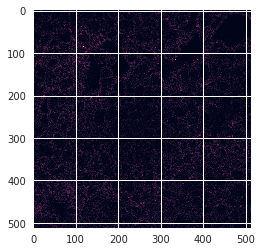

In [206]:
plt.imshow(image[:,:,3])

In [207]:
Image.fromarray(image).save('test_4channel.png')

In [14]:
ch4_image = Image.open('test_4channel.png')

FileNotFoundError: [Errno 2] No such file or directory: 'test_4channel.png'

In [209]:

ch4_image = np.array(ch4_image)

In [226]:
use_channel = [0,1,2]
ch4_image[:,:,use_channel].shape

(512, 512, 3)

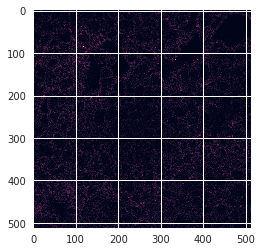

In [210]:
plt.imshow(ch4_image[:,:,3])

In [12]:
dataset = AtlasTrainDataset('./data/')

In [13]:
image, label = dataset[0]

TypeError: load_image() takes from 1 to 2 positional arguments but 3 were given

In [228]:
def create_4ch_for_test():
    submit = pd.read_csv('./data/sample_submission.csv')
    for name in submit['Id']:
        path = os.path.join('./data/test/', name)
        print(path)
        image_array = AtlasTrainDataset.load_image(path)
        save_path = '{}_rgby.png'.format(path)
        print('save to {}'.format(save_path))
        Image.fromarray(image_array).save(save_path)

In [6]:
import numpy as np
pred = np.array([[0.5, 0.1, 0.2], [0.3, 0.8, 0.7]])
pred>0.5

array([[False, False, False],
       [False,  True,  True]])

In [7]:
def test(array):
    array[array>0.5] = 1
    return array

In [8]:
b = test(pred)
print(b)
print(pred)

[[0.5 0.1 0.2]
 [0.3 1.  1. ]]
[[0.5 0.1 0.2]
 [0.3 1.  1. ]]


In [19]:
image = Image.open('./data/train/77e63118-bbad-11e8-b2ba-ac1f6b6435d0_green.png')

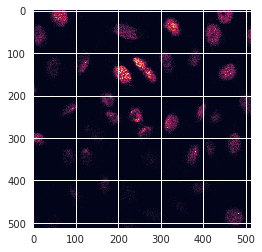

In [27]:
plt.imshow(np.array(image))

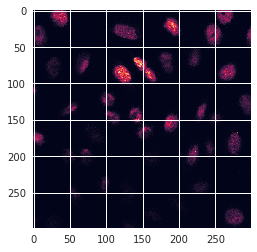

In [24]:
plt.imshow(cv2.resize(np.array(image), (299,299)))

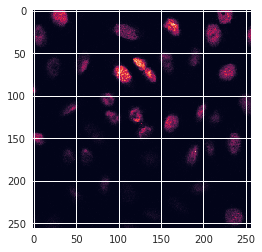

In [25]:
plt.imshow(cv2.resize(np.array(image), (256,256)))

In [28]:
y_train = np.load('./data/npy_data/y_train_rgb_256.npy')
y_valid = np.load('./data/npy_data/y_valid_rgb_256.npy')

In [34]:
print(y_train.shape, y_valid.shape)
train_hist = np.sum(y_train, axis=0)
valid_hist = np.sum(y_valid, axis=0)

(24857, 28) (6215, 28)


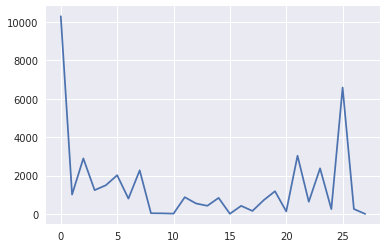

In [35]:
plt.plot(train_hist)

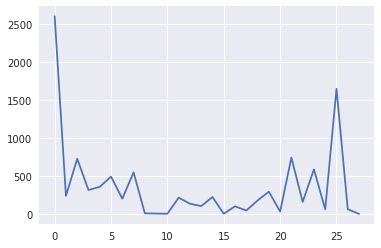

In [37]:
plt.plot(valid_hist)